# Forward Simulation of 2D VEP model at Sensor level

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [4]:
cwd = os.getcwd()
cwd

'/mnt/0582b5ea-dc43-4c17-8a69-29b39f3fc394/VEP_benchmark/VEP_Optimization_Benchmark'

In [5]:
Res_dir='data_output_files'

To build a whole-brain network model, the brain regions (network nodes) are defined using a parcellation scheme and a set of mathematical equations is placed at each network node to model the regional brain activity \citep{Sanz-Leon2015, Jirsa2016}. Taking such a data-driven approach to incorporate the subject-specific brain's anatomical information, the network edges are then represented by structural connectivity (SC) matrix which is obtained from non-invasive diffusion imaging data (dMRI) of the subject \citep{Jirsa2016, Bansal2018}. Neural mass models are flexible, and physiologically realistic, providing a tractable framework for the analysis of local neural population dynamics by averaging microscopic structure and activity \citep{Jirsa96, Jirsa2016, Muller2020}. Neural mass modeling has proven its efficiency in capturing the main features of brain functional behaviors in a single computational framework, by accounting for interactions among brain regions \citep{Jirsa04_Rev, David+Friston03, Deco2009, Deco2011, Spiegler_etal11, Hashemi14, Hashemi15, Courtiol2020}.

In the VEP model---a personalized whole-brain network model of epilepsy  \citep{Jirsa2016}---, the dynamics of brain regions are governed by Epileptor model \citep{Jirsa2014}. The Epileptor is a general description of epileptic seizures, which contains the complete taxonomy of system bifurcations to realistically reproduce the dynamics of onset, progression, and offset of seizure-like events \citep{Saggio2020}. The full Epileptor comprises five state variables coupling two oscillatory dynamical systems on three different time-scales (Jirsa et al Brain 2014).


By applying averaging methods, the effect of the second neuronal ensemble of Epileptor  is negligible \citep{Proix2014}. Then motivated by Synergetic theory \citep{Haken1997, JirsaHaken1997} and under time-scale separation, the fast variables rapidly collapse on the slow manifold \citep{McIntoshJirsa2019}, whose dynamics is governed by the slow variable $z$. This adiabatic approximation yields the 2D reduction of VEP model as follows:


\begin{eqnarray}
\label{2DVEP}
\dot{x_{i}} &=&1 - x_{i}^3 -2 x_{i}^2- z_{i} + I_1 \nonumber \\
\dot{z_i} &=& \dfrac{1}{\tau}(4 (x_{i} - \eta_{i}) - z_{i} - K \sum_{j=1}^{N} C_{ij}(x_{j}-x_{i})), \nonumber\\
\end{eqnarray}

where $x_i$ and $z_i$ indicate the fast and slow variables corresponding to $i$-th brain region, respectively, and the set of unknown $\eta_i$ is the spatial map of epileptogenicity.

 The parameters $I_1$ represent the flow of electric currents as $I_1=3.1$. The degree of epileptogenicity at each brain region is represented through the value of the excitability parameter $\eta_i$ (Hopf bifurcation parameter). The network nodes are coupled by a linear diffuse approximation of permittivity coupling through $K \sum_{j=1}^{N} C_{ij}(x_{1,j}-x_{1,i})$, which includes a global scaling factor $K$, and the patient's connectome $C_{ij}$.

\subsection{Generative model}
\label{GM}


Given a set of observations, the generative model is a probabilistic description of the mechanisms by which observed data are generated through some hidden states (not directly observable) and unknown parameters (not directly measurable). Here, the generative model will therefore have a mathematical formulation guided by the dynamical model that describes the evolution of the model's state variables, given parameters, over time \citep{Daunizeau2009, Daunizeau2014, Hashemi2020}. In Bayesian set up, this specification is necessary to construct the likelihood function \citep{Cooray2015, Hashemi2018}. The full generative model is then completed by specifying prior beliefs (e.g.,  dynamical properties and/or clinical knowledge) about the possible values of the unknown parameters \citep{Friston2014b}.

Notably, the changes in parameter(s) of generative models account for the changes in observations, and the estimation of these parameters enables inference on hidden states that underwrite the changes in observed data, forming the basis for predicting new measurements, causal hypothesis testing, and consensus-based decision making \citep{Friston_2003, Pearl2009, Hashemi2020}. This approach allows us to infer the probability of past and future events, as well as the dynamics of beliefs under changing conditions for generating novel hypotheses where new experiments are prohibitively difficult or impossible to perform \citep{pearl_2009}.


In this study, the generative model is formulated on the basis of a system of non-linear differential equations of the form (so-called state-space representation or evolution equations):


$
\begin{eqnarray}
\dot{\boldsymbol{X}} (t) &=&\boldsymbol{F}(\boldsymbol{X} (t) ,\boldsymbol{u}(t) , \boldsymbol{\theta})+ \boldsymbol{w}(t), ~~~~ \boldsymbol{X}(t=0)=\boldsymbol{X_{t_0}}\\
\boldsymbol{Y}(t)& =&\boldsymbol{H}(\boldsymbol{X} (t) )+\boldsymbol{v}(t)
\end{eqnarray}
$


where $\boldsymbol{X}(t) \in\mathbb{R}^{N_n}$ is the $N_n$-dimensional vector of system states evolving over time, $\boldsymbol{X_{t_0}}$ is the initial state vector at time $t=0$, $\boldsymbol{\theta} \in\mathbb{R}^{N_p}$ contains all the unknown  parameters, $\boldsymbol{u}(t)$ stands for the external input, and $\boldsymbol{Y}(t) \in\mathbb{R}^{N_s}$ denotes the measured data subject to the measurement error $\boldsymbol{v}(t)$.

The process (dynamical) noise and the measurement noise denoted by $\boldsymbol{w}(t) \sim \mathcal N(0, {\sigma}^2)$ and $\boldsymbol{v}(t) \sim \mathcal N(0, {\sigma^{\prime}}^2)$, respectively, are independent and assumed to follow a Gaussian distribution with mean zero and variance $\sigma^2$ and ${\sigma^{\prime}}^2$, respectively. Moreover, $\boldsymbol{f}(.)$ is a vector function that describes the dynamical properties of the system i.e., summarizing the biophysical mechanisms underlying the temporal evolution of system states (here, governed by the VEP model), and $\boldsymbol{H}(.)$ represents a measurement function i.e., the instantaneous mapping from system states to observations (here, the gain matrix).

For the sake of simplicity, we assume ordinary differential equation by setting the noise level to zero. More importantly. to avoid non-identifiability issue, we assume an unique bijection to measurement: H=I (identity matrix).

Considering the above formulation, then $\boldsymbol{X}(t)=(x_{1}(t), z_{1}(t), x_{2}(t), z_{2}(t), ...,   x_{N_n}(t),  z_{N_n}(t))$, where $N_n$ is equal to the total number of brain regions (here 84). 
By fixing the initial values and the time-scale $\tau$, the parameter set to estimate is $\boldsymbol{\theta}=(\eta_{1}, \eta_{2}, ..., \eta_{N_n}, K) \in\mathbb{R}^{N_p}$, where $N_p=N_n+1$. The observation for fitting is considered as only fast variable activity in VEP model ($x_{i}(t)$).


\subsection{Spatial Map of Epileptogenicity}
\label{SME}


In the VEP, each brain region can trigger seizures depending on its excitability value (node dynamics) and the connectivity to others (network coupling). The parameter $\eta$ controls the tissue excitability, and its spatial distribution is thus the target of parameter fitting. In this study, depending on the excitability parameter, the different brain regions are classified into three main types:

\begin{itemize}
\item Epileptogenic Zone (EZ): if $ \eta>\eta_{c} $, the brain region can trigger seizures autonomously responsible for the origin and early organization of the epileptic activity. For these regions, the Epileptor exhibits an unstable fixed point, allowing a seizure to happen without a dependency on the network effects.

\item Propagation Zone (PZ): if $\eta_{c} - \Delta \eta < \eta < \eta_{c}$, the brain region does not trigger seizures autonomously but it may be recruited during the seizure evolution through network effects since its equilibrium state is close to the critical value. For these regions, by a sufficiently large value of external input, a supercritical Andronov-Hopf bifurcation occurs at $\eta=\eta_{c}$ corresponding to seizure onset, otherwise, the Epileptor is in its stable equilibrium state.

\item Healthy Zone (HZ): if $\eta < \eta_{c} - \Delta \eta$, the brain region stays away from triggering seizures, and all the trajectories in phase-plane are attracted to the single stable fixed point of Epileptor.


\end{itemize}



Based on the above dynamical properties, the spatial map of epileptogenicity across different brain regions comprises the excitability values of EZ (high value of excitability), PZ (smaller excitability values), and all other regions categorized as HZ (not epileptogenic). Note, however, that an intermediate excitability value does not guarantee that the seizures recruit this area as part of the propagation zone, because the recruitment is also determined by various other factors including structural connectivity, network coupling, and brain state dependence. Using linear stability analysis, isolated nodes displayed a bifurcation at the critical value $\eta_{c}=-2.05$ \citep{Proix2014, Olmi2019}, and we set $\Delta \eta=1.0$ \citep{Hashemi2020}.

## Objective function

For now, we focuse on source level activity rather than sensor measurement to avoid non-identifiability. 
If we assume Gain matrix is an indenitiy matrix $G=I$, then SEEG=G*X, then we need to fit X, where X=x_i for each node, is given by fast-variable of Epileptor model.
So, at the source level, the target of fitting (observation) is the tme series x_i (here, i=1,2,...,84).
Then, the parameter to estimate will be $-5.<\eta_i<0.$ for i=1,2,...,84, and $0<K<2$ as the coupling term. Thus for N=84, we have N+1=85 parameters to estimate.



# Patient CJ

In the following we first load the patient connectivity matrix. Then we place an Epileptor model at each region (node), and connect them by connectivity matrix to simulate brain activity at regional level (Source brain activity).

## Structural Connectivity and Gain Matrices

In [6]:
weights = np.loadtxt(os.path.join(cwd+"/ExperimentalData/connectivity", "weights.txt"))

In [7]:
# normalize Connectome
weights = weights/np.max(weights)
num_regions = len(weights)

In [8]:
weights.min(), weights.max()

(0.0, 1.0)

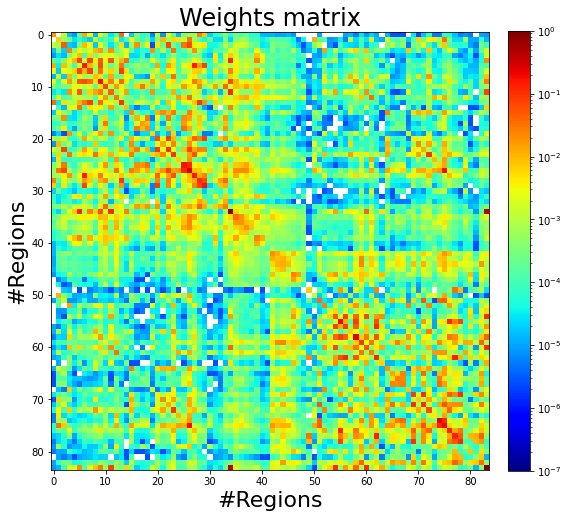

In [9]:
plt.figure(figsize=(8, 8))

norm = colors.LogNorm(1e-7, weights.max())
im = plt.imshow(weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Weights matrix', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)
plt.tight_layout()
plt.show()

## ROIs chosen as Epileptogenic/propagation zones

In [10]:
# here we set the ground-truth

hz_val=-3.5 
pz_val=-2.06
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_idx = np.array([5, 11, 27],  dtype=np.int32)

In [11]:
ez_idx

array([ 6, 34], dtype=int32)

In [12]:
pz_idx

array([ 5, 11, 27], dtype=int32)

In [13]:
#Here, we increase manually the weights between EZ and PZ to get propagation:
# weights[np.ix_(np.array([5,11]), ez_idx)] = 4.0
# weights[np.ix_(np.array([27]), ez_idx)] = 1.0

In [14]:
# SC is given to simulator as fixed values (at the end we use this matrix to connect the nodes.) 
SC=weights
SC.shape

(84, 84)

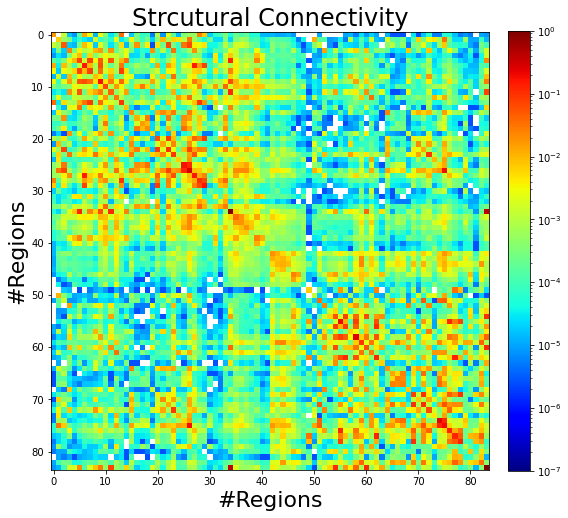

In [15]:
plt.figure(figsize=(8, 8))
norm = colors.LogNorm(1e-7, SC.max())
im = plt.imshow(SC,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Strcutural Connectivity', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)
plt.tight_layout()
plt.show()

In [16]:
Gain = np.loadtxt(os.path.join(cwd+"/ExperimentalData", "gain_inv-square.txt"))

In [17]:
Gain.shape

(162, 84)

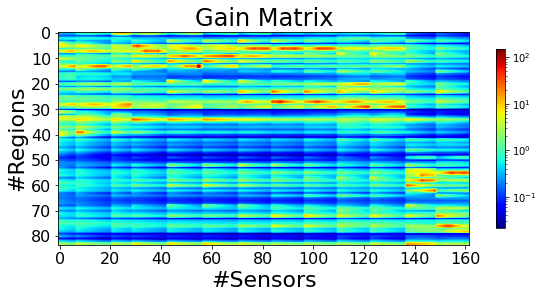

In [18]:
plt.figure(figsize=(8, 4))
norm = colors.LogNorm(Gain.min(), Gain.max())
im = plt.imshow(Gain.transpose(),norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.02, pad=0.06)
plt.gca().set_title('Gain Matrix', fontsize=24.0)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16, rotation=0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Sensors', fontsize=22.0)
plt.show()

### Simulator

In [19]:
@jit(nopython=False) 
def VEP2Dmodel_sensor(params, constants, init_conditions, SC, Gain, dt, ts):
    
    nt=ts.shape[0]
    nn=SC.shape[0]
    ns=Gain.shape[0]

    #parameters
    eta=params[0:nn]
    K=params[-1]
    
    # fixed parameters
    tau0, I1, sigma=constants[0], constants[1], constants[2]


    # simulation from initial point
    x = np.zeros((nn, nt))  # fast voltage
    z = np.zeros((nn, nt))  # slow voltage

    # initial conditions
    x_init, z_init=init_conditions[0], init_conditions[1]
    for i in range(0, nn):
          x[i, 0] = x_init
          z[i, 0] = z_init
    

    # integrate ODE
    for t in range(0, nt-1):
        for i in range(0, nn):
            gx = 0;
            for j in range(0, nn):
                    gx = gx + SC[i, j]*(x[j, t] - x[i, t]);
            dx = 1.0 -  np.power(x[i, t], 3) - 2.0*np.power(x[i, t], 2) - z[i, t] + I1;
            dz = (1./tau0)*(4.*(x[i, t] - eta[i]) - z[i, t] - K*gx);
            x[i, t+1] = x[i, t] + dt*dx + np.sqrt(dt) * sigma * np.random.randn() 
            z[i, t+1] = z[i, t] + dt*dz + np.sqrt(dt) * sigma * np.random.randn()  
  
    Seeg= np.dot(Gain, np.exp(x))
    
    return np.concatenate((Seeg.reshape(-1), x.reshape(-1) , z.reshape(-1) )) 

### A simulations for  sanity check

In [20]:
T = 80.0
dt=0.1
ts = np.arange(0, T + dt, dt)

In [21]:
nt=ts.shape[0]
nt

801

In [22]:
nn=SC.shape[0]
nn

84

In [23]:
ns=Gain.shape[0]
ns

162

In [24]:
tau0=90.
I1=3.1    
sigma=0.01 # we assume ODE so no noise in the system
constants = np.array([tau0, I1, sigma])

In [25]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [26]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [27]:
K_true=1. # global copuling parameters

In [28]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [29]:
start_time = time.time()
Sim = VEP2Dmodel_sensor(params_true, constants, init_conditions, SC, Gain, dt, ts)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 1.7028968334197998


In [30]:
start_time = time.time()
Sim_true = VEP2Dmodel_sensor(params_true, constants, init_conditions, SC, Gain, dt, ts)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.042971134185791016


In [31]:
Sim_true.shape

(264330,)

In [32]:
Seeg_true=Sim_true[0:(ns*nt)].reshape(ns, nt)
X_true=Sim_true[(ns*nt):(ns*nt)+(nn*nt)].reshape(nn, nt)
Z_true=Sim_true[(ns*nt)+(nn*nt):(ns*nt)+(2*nn*nt)].reshape(nn, nt)

In [33]:
Seeg_true.shape, X_true.shape, Z_true.shape

((162, 801), (84, 801), (84, 801))

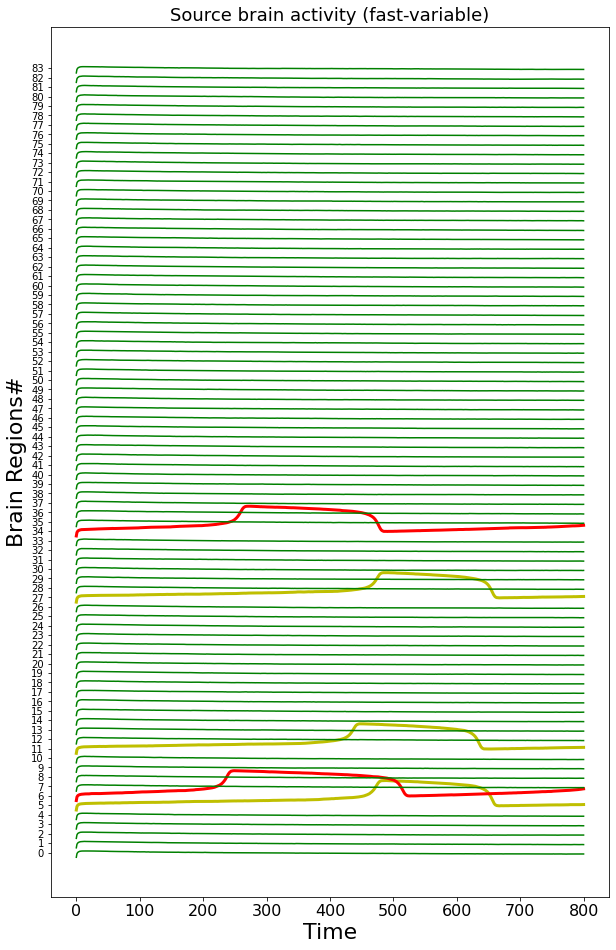

In [34]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X_true[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X_true[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(X_true[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity (fast-variable)",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

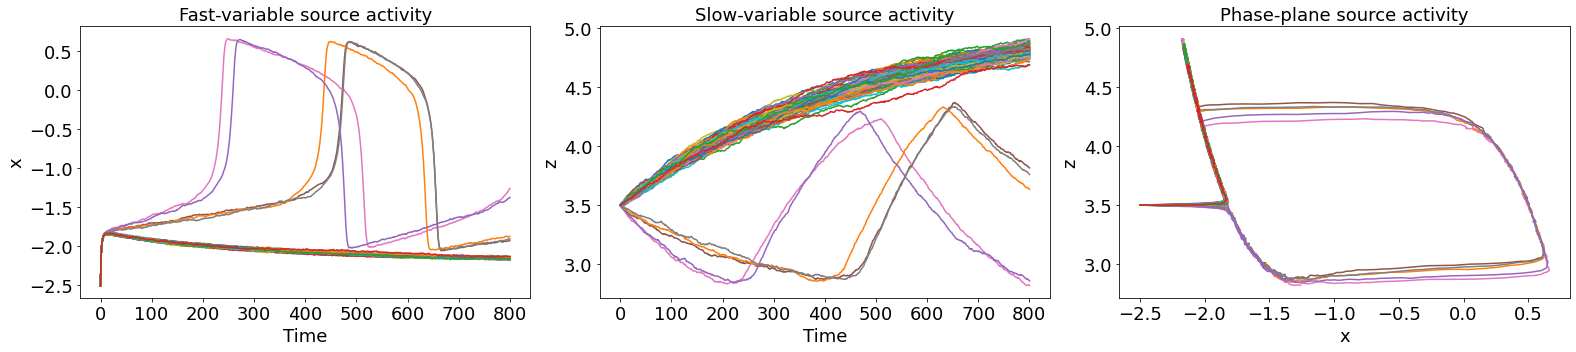

In [35]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(X_true.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('x',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Fast-variable source activity",fontsize=18)

plt.subplot(132)
plt.plot(Z_true.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Slow-variable source activity",fontsize=18)


plt.subplot(133)
plt.plot(X_true.T, Z_true.T);
plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Phase-plane source activity",fontsize=18)

plt.tight_layout()
plt.show()

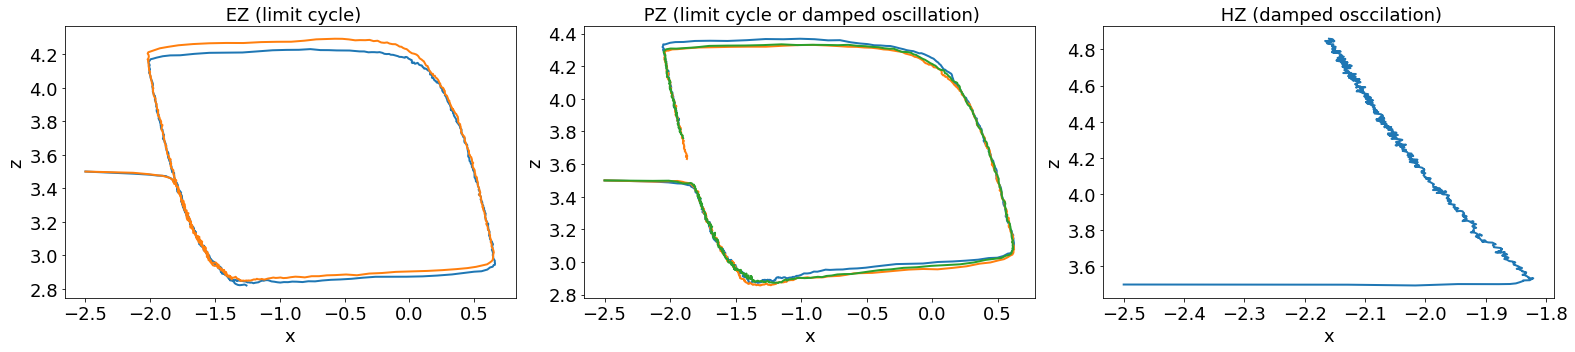

In [36]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(X_true[ez_idx].T, Z_true[ez_idx].T, lw=2);
plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" EZ (limit cycle)",fontsize=18)

plt.subplot(132)
plt.plot(X_true[pz_idx].T, Z_true[pz_idx].T, lw=2);
plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" PZ (limit cycle or damped oscillation)",fontsize=18)


plt.subplot(133)
plt.plot(X_true[1].T, Z_true[1].T, lw=2);
plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" HZ (damped osccilation)",fontsize=18)

plt.tight_layout()
plt.show()

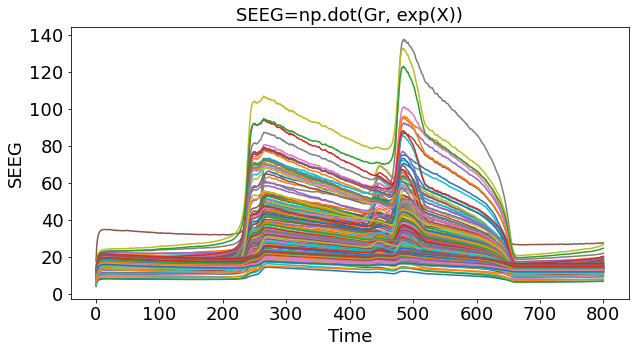

In [37]:
plt.figure(figsize=(10,5))
plt.plot(Seeg_true.T);
plt.xlabel('Time',fontsize=18)
plt.ylabel('SEEG',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("SEEG=np.dot(Gr, exp(X))",fontsize=18)
plt.show()

# Objective function

In [38]:
Seeg_true.shape

(162, 801)

In [39]:
Seeg_obs=Seeg_true

In [40]:
b=-5.
a=0.0
incer=0.1

In [41]:
prior_range=np.arange(b,a,incer)
prior_range

array([-5. , -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4. ,
       -3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3. , -2.9,
       -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8,
       -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7,
       -0.6, -0.5, -0.4, -0.3, -0.2, -0.1])

In [42]:
eta_true

array([-3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -2.06, -1.6 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -2.06, -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -2.06, -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -1.6 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 ])

In [43]:
K_true

1.0

In [44]:
params_true=np.append(eta_true, K_true)
params_true

array([-3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -2.06, -1.6 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -2.06, -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -2.06, -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -1.6 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 ,  1.  ])

In [45]:
def sweep_function(params_true, prior_range, Seeg_obs, node_idx):
    
    Sweep_len=prior_range.shape[0]
    RMSE=np.zeros((Sweep_len))
    
    params_val=np.append(eta_true, K_true)
    
    ii=0
    for i in prior_range:
        params_val[node_idx]=i
        
        Sim =VEP2Dmodel_sensor(params_val, constants, init_conditions, SC, Gain, dt, ts)
        Seeg_model=Sim[0:(ns*nt)].reshape(ns, nt)
        
        RMSE[ii]=np.sqrt(np.sum((Seeg_model-Seeg_obs)**2))
        
        ii=ii+1
        
    return RMSE

In [46]:
RMSE_nodeidx_N6=sweep_function(params_true, prior_range, Seeg_obs, node_idx=6)
RMSE_nodeidx_N34=sweep_function(params_true, prior_range, Seeg_obs, node_idx=34)

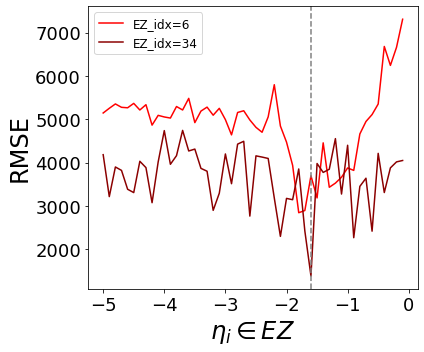

In [47]:
plt.figure(figsize=(6,5))

colours=['r', 'darkred']

plt.plot(prior_range, RMSE_nodeidx_N6, color=colours[0], markersize=4, label='EZ_idx='+str(ez_idx[0]),);
plt.plot(prior_range, RMSE_nodeidx_N34, color=colours[1], markersize=4, label='EZ_idx='+str(ez_idx[1]),);
    
plt.axvline(x=ez_val, color='grey', linestyle='--')

plt.ylabel('RMSE',fontsize=24)
plt.xlabel('$\eta_i \in EZ$',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

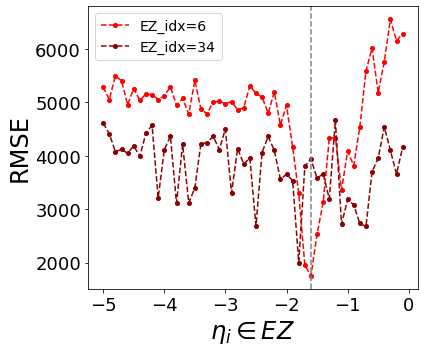

In [48]:
plt.figure(figsize=(6,5))

colours=['r', 'darkred']

for i in np.arange(len(ez_idx)):
    RMSE_nodeidx_=sweep_function(params_true, prior_range, Seeg_obs, node_idx=ez_idx[i])
    plt.plot(prior_range,RMSE_nodeidx_, '--o', label='EZ_idx='+str(ez_idx[i]), color=colours[i], markersize=4);
    
plt.axvline(x=ez_val, color='grey', linestyle='--')

plt.ylabel('RMSE',fontsize=24)
plt.xlabel('$\eta_i \in EZ$',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.tight_layout()

plt.show()

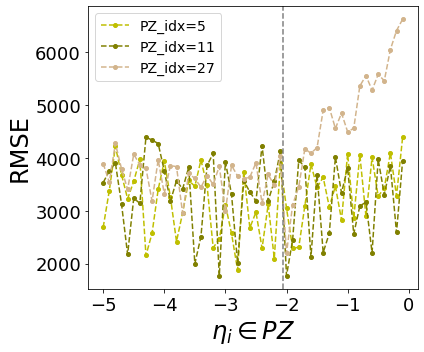

In [49]:
plt.figure(figsize=(6,5))

colours=['y', 'olive', 'tan']

for i in np.arange(len(pz_idx)):
    RMSE_nodeidx_=sweep_function(params_true, prior_range, Seeg_obs, node_idx=pz_idx[i])
    plt.plot(prior_range,RMSE_nodeidx_, '--o', label='PZ_idx='+str(pz_idx[i]), color=colours[i], markersize=4);
plt.axvline(x=pz_val, color='grey', linestyle='--')

plt.ylabel('RMSE',fontsize=24)
plt.xlabel('$\eta_i \in PZ$',fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.tight_layout()
plt.show()

In [50]:
params_true=np.append(eta_true, K_true)
params_true

array([-3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -2.06, -1.6 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -2.06, -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -2.06, -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -1.6 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 , -3.5 ,
       -3.5 , -3.5 , -3.5 ,  1.  ])

In [51]:
from random import  uniform

eta_r = [uniform(-5, 0) for i in range(84)]
K_r = [uniform(0, 2) for i in range(1)]

In [52]:
params_guess=np.append(eta_r, K_r)

In [53]:
def Cost_function(params, Seeg_obs):
    
    Sim =VEP2Dmodel_sensor(params, constants, init_conditions, SC, Gain, dt, ts)
    Seeg_model=Sim[0:(ns*nt)].reshape(ns, nt)
        
    RMSE=np.sqrt(np.sum((Seeg_model-Seeg_obs)**2))

    return RMSE

In [54]:
Cost_function(params_guess, Seeg_obs)

15325.12241876823

In [55]:
# np.save('Problem6_X_true_sdeK0Sig01.npy', X_true)
# np.save('Problem6_Z_true_sdeK0Sig01.npy', Z_true)
# np.save('Problem6_Seeg_true_sdeK0Sig01.npy', Seeg_true)